Time series data is an important form of structured data in many different fields, such
as finance, economics, ecology, neuroscience, and physics. Anything that is observed
or measured at many points in time forms a time series. Many time series are fixed
frequency, which is to say that data points occur at regular intervals according to some
rule, such as every 15 seconds, every 5 minutes, or once per month. Time series can
also be irregular without a fixed unit of time or offset between units. How you mark
and refer to time series data depends on the application, and you may have one of the
following:   
   
   
• Timestamps, specific instants in time
   
     
     
• Fixed periods, such as the month January 2007 or the full year 2010
   
     
• Intervals of time, indicated by a start and end timestamp. Periods can be thought
of as special cases of intervals
   
     
• Experiment or elapsed time; each timestamp is a measure of time relative to a
particular start time (e.g., the diameter of a cookie baking each second since
being placed in the oven)

In this chapter, I am mainly concerned with time series in the first three categories,
though many of the techniques can be applied to experimental time series where the
index may be an integer or floating-point number indicating elapsed time from the
start of the experiment. The simplest and most widely used kind of time series are
those indexed by timestamp.

pandas also supports indexes based on timedeltas, which can be a
useful way of representing experiment or elapsed time. We do not
explore timedelta indexes in this book, but you can learn more in
the pandas documentation.

pandas provides many built-in time series tools and data algorithms. You can effi‐
ciently work with very large time series and easily slice and dice, aggregate, and
resample irregular- and fixed-frequency time series. Some of these tools are especially
useful for financial and economics applications, but you could certainly use them to
analyze server log data, too.


## 11.1 Date and Time Data Types and Tools

The Python standard library includes data types for date and time data, as well as
calendar-related functionality. The datetime, time, and calendar modules are the
main places to start. The datetime.datetime type, or simply datetime, is widely
used:


In [1]:
from datetime import datetime
now = datetime.now()
now

datetime.datetime(2024, 2, 1, 18, 49, 34, 161041)

In [2]:
now.year, now.month, now.day

(2024, 2, 1)

datetime stores both the date and time down to the microsecond. timedelta repre‐
sents the temporal difference between two datetime objects:

In [3]:
delta = datetime(2011, 1, 7) - datetime(2008, 6, 24, 8, 15)
delta

datetime.timedelta(926, 56700)

In [4]:
delta.days

926

In [5]:
delta.seconds

56700

You can add (or subtract) a timedelta or multiple thereof to a datetime object to
yield a new shifted object:

In [6]:
from datetime import timedelta
start = datetime(2011, 1, 7)
start + timedelta(12)

datetime.datetime(2011, 1, 19, 0, 0)

In [7]:
start - 2 * timedelta(12)

datetime.datetime(2010, 12, 14, 0, 0)

Table 11-1. Types in datetime module
------------------------------------------------------
Type --> Description
  
    
date --> Store calendar date (year, month, day) using the Gregorian calendar

    
    
time -->  Store time of day as hours, minutes, seconds, and microseconds
  
    
datetime --> Stores both date and time
  
     
timedelta --> Represents the difference between two datetime values (as days, seconds, and microseconds)
  
     
tzinfo --> Base type for storing time zone information

## Converting Between String and Datetime


You can format datetime objects and pandas Timestamp objects, which I’ll introduce
later, as strings using str or the strftime method, passing a format specification:

In [8]:
stamp = datetime(2011, 1, 3)

In [9]:
str(stamp)

'2011-01-03 00:00:00'

In [10]:
stamp.strftime('%Y-%m-%d')

'2011-01-03'

Table 11-2. Datetime format specification (ISO C89 compatible)
-----------------------------------------------------------------------------------------
   
   
Type --> Description
   
   
%Y --> Four-digit year
  
   
%y --> Two-digit year
  
   
%m --> Two-digit month [01, 12]
  
   
%d--> Two-digit day [01, 31]
   
   
%H --> Hour (24-hour clock) [00, 23]
  
   
%I --> Hour (12-hour clock) [01, 12]
  
   
%M --> Two-digit minute [00, 59]
   
    
%S --> Second [00, 61] (seconds 60, 61 account for leap seconds)
  
   
%w --> Weekday as integer [0 (Sunday), 6]
  
   
%U --> Week number of the year [00, 53]; Sunday is considered the first day of the week, and days before the first Sunday of the year are “week 0”
  
   
%W --> Week number of the year [00, 53]; Monday is considered the first day of the week, and days before the first Monday of the year are “week 0”  
  
%z --> UTC time zone offset as +HHMM or -HHMM; empty if time zone naive
  
    
%F --> Shortcut for %Y-%m-%d (e.g., 2012-4-18)
  
    
%D--> Shortcut for %m/%d/%y (e.g., 04/18/12)

You can use these same format codes to convert strings to dates using date
time.strptime:


In [11]:
value = '2011-01-03'
datetime.strptime(value, '%Y-%m-%d')

datetime.datetime(2011, 1, 3, 0, 0)

In [12]:
datestrs = ['7/6/2011', '8/6/2011']
[datetime.strptime(x, '%m/%d/%Y') for x in datestrs]

[datetime.datetime(2011, 7, 6, 0, 0), datetime.datetime(2011, 8, 6, 0, 0)]

datetime.strptime is a good way to parse a date with a known format. However, it
can be a bit annoying to have to write a format spec each time, especially for common
date formats. In this case, you can use the parser.parse method in the third-party
dateutil package (this is installed automatically when you install pandas):

In [13]:
from dateutil.parser import parse
parse('2011-01-03')

datetime.datetime(2011, 1, 3, 0, 0)

dateutil is capable of parsing most human-intelligible date representations:

In [14]:
parse('Jan 31, 1997 10:45 PM')

datetime.datetime(1997, 1, 31, 22, 45)

In international locales, day appearing before month is very common, so you can pass
dayfirst=True to indicate this:


In [15]:
parse('6/12/2011', dayfirst=True)

datetime.datetime(2011, 12, 6, 0, 0)

pandas is generally oriented toward working with arrays of dates, whether used as an
axis index or a column in a DataFrame. The to_datetime method parses many dif‐
ferent kinds of date representations. Standard date formats like ISO 8601 can be
parsed very quickly:

In [16]:
import pandas as pd
datestrs = ['2011-07-06 12:00:00', '2011-08-06 00:00:00']
pd.to_datetime(datestrs)

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00'], dtype='datetime64[ns]', freq=None)

It also handles values that should be considered missing (None, empty string, etc.):

In [17]:
idx = pd.to_datetime(datestrs + [None])
idx

DatetimeIndex(['2011-07-06 12:00:00', '2011-08-06 00:00:00', 'NaT'], dtype='datetime64[ns]', freq=None)

In [18]:
pd.isnull(idx)

array([False, False,  True])

NaT (Not a Time) is pandas’s null value for timestamp data.

dateutil.parser is a useful but imperfect tool. Notably, it will rec‐
ognize some strings as dates that you might prefer that it didn’t—
for example, '42' will be parsed as the year 2042 with today’s cal‐
endar date.

datetime objects also have a number of locale-specific formatting options for systems
in other countries or languages. For example, the abbreviated month names will be
different on German or French systems compared with English systems. See
Table 11-3 for a listing.

Table 11-3. Locale-specific date formatting
--------------------------------------------------------------
 
  
Type --> Description
  
    
%a --> Abbreviated weekday name
   
    
%A --> Full weekday name
   
    
%b --> Abbreviated month name
  
    
%B --> Full month name
  
    
%c --> Full date and time (e.g., ‘Tue 01 May 2012 04:20:57 PM’)
   
    
%p --> Locale equivalent of AM or PM
   
    
%x --> Locale-appropriate formatted date (e.g., in the United States, May 1, 2012 yields ’05/01/2012’)
  
    
%X --> Locale-appropriate time (e.g., ’04:24:12 PM’)

## 11.2 Time Series Basics

A basic kind of time series object in pandas is a Series indexed by timestamps, which
is often represented external to pandas as Python strings or datetime objects:


In [19]:
from datetime import datetime
import numpy as np
dates = [datetime(2011, 1, 2), datetime(2011, 1, 5),datetime(2011, 1, 7), datetime(2011, 1, 8),datetime(2011, 1, 10), datetime(2011, 1, 12)]
ts = pd.Series(np.random.randn(6), index=dates)
ts

2011-01-02    1.360881
2011-01-05    1.588839
2011-01-07    1.263487
2011-01-08    0.380473
2011-01-10   -0.398274
2011-01-12   -0.001841
dtype: float64

Under the hood, these datetime objects have been put in a DatetimeIndex:


In [20]:
ts.index

DatetimeIndex(['2011-01-02', '2011-01-05', '2011-01-07', '2011-01-08',
               '2011-01-10', '2011-01-12'],
              dtype='datetime64[ns]', freq=None)

Like other Series, arithmetic operations between differently indexed time series auto‐
matically align on the dates:

In [21]:
ts + ts[::2]


2011-01-02    2.721761
2011-01-05         NaN
2011-01-07    2.526974
2011-01-08         NaN
2011-01-10   -0.796548
2011-01-12         NaN
dtype: float64

Recall that ts[::2] selects every second element in ts

pandas stores timestamps using NumPy’s datetime64 data type at the nanosecond
resolution:

In [22]:
ts.index.dtype

dtype('<M8[ns]')

Scalar values from a DatetimeIndex are pandas Timestamp objects:

In [23]:
stamp = ts.index[0]
stamp

Timestamp('2011-01-02 00:00:00')

A Timestamp can be substituted anywhere you would use a datetime object. Addi‐
tionally, it can store frequency information (if any) and understands how to do time
zone conversions and other kinds of manipulations. More on both of these things
later.

### Indexing, Selection, Subsetting

Time series behaves like any other pandas.Series when you are indexing and select‐
ing data based on label:

In [24]:
stamp = ts.index[2]
ts[stamp]

1.2634867684171263

As a convenience, you can also pass a string that is interpretable as a date:

In [25]:
ts['1/10/2011']

-0.3982740492989236

In [26]:
ts['20110110']

-0.3982740492989236

For longer time series, a year or only a year and month can be passed to easily select
slices of data:


In [27]:
longer_ts = pd.Series(np.random.randn(1000),index=pd.date_range('1/1/2000', periods=1000))
longer_ts

2000-01-01   -1.491293
2000-01-02   -0.715757
2000-01-03    0.720026
2000-01-04    0.180061
2000-01-05   -0.847882
                ...   
2002-09-22   -0.904333
2002-09-23   -0.085103
2002-09-24    1.666455
2002-09-25    1.434788
2002-09-26   -0.814945
Freq: D, Length: 1000, dtype: float64

In [28]:
longer_ts['2001']

2001-01-01    2.871712
2001-01-02   -0.285574
2001-01-03   -0.439809
2001-01-04    0.276261
2001-01-05   -0.111729
                ...   
2001-12-27    0.384475
2001-12-28    1.054383
2001-12-29    0.035259
2001-12-30    0.023945
2001-12-31   -1.593310
Freq: D, Length: 365, dtype: float64

Here, the string '2001' is interpreted as a year and selects that time period. This also
works if you specify the month:


In [29]:
longer_ts['2001-05']


2001-05-01    0.060366
2001-05-02   -0.277113
2001-05-03    0.941605
2001-05-04   -1.014376
2001-05-05    0.704992
2001-05-06    0.330377
2001-05-07   -0.045300
2001-05-08    0.743415
2001-05-09   -0.641960
2001-05-10   -0.595122
2001-05-11    0.614129
2001-05-12    0.870157
2001-05-13   -0.072094
2001-05-14   -0.182173
2001-05-15   -0.868522
2001-05-16   -0.209398
2001-05-17   -1.784163
2001-05-18    0.034902
2001-05-19    0.017078
2001-05-20    0.282310
2001-05-21    0.858742
2001-05-22   -1.252718
2001-05-23   -1.180368
2001-05-24   -0.561969
2001-05-25    0.311400
2001-05-26    0.459353
2001-05-27    0.229915
2001-05-28   -1.678542
2001-05-29    0.081242
2001-05-30   -0.787674
2001-05-31   -1.948675
Freq: D, dtype: float64

Slicing with datetime objects works as well:

In [30]:
ts[datetime(2011, 1, 7):]

2011-01-07    1.263487
2011-01-08    0.380473
2011-01-10   -0.398274
2011-01-12   -0.001841
dtype: float64

Because most time series data is ordered chronologically, you can slice with time‐
stamps not contained in a time series to perform a range query:

In [31]:
ts

2011-01-02    1.360881
2011-01-05    1.588839
2011-01-07    1.263487
2011-01-08    0.380473
2011-01-10   -0.398274
2011-01-12   -0.001841
dtype: float64

In [32]:
ts['1/6/2011':'1/11/2011']

2011-01-07    1.263487
2011-01-08    0.380473
2011-01-10   -0.398274
dtype: float64

As before, you can pass either a string date, datetime, or timestamp. Remember that
slicing in this manner produces views on the source time series like slicing NumPy
arrays. This means that no data is copied and modifications on the slice will be reflec‐
ted in the original data.
  
      
There is an equivalent instance method, truncate, that slices a Series between two
dates:

In [33]:
ts.truncate(after='1/9/2011')

2011-01-02    1.360881
2011-01-05    1.588839
2011-01-07    1.263487
2011-01-08    0.380473
dtype: float64

All of this holds true for DataFrame as well, indexing on its rows:

In [34]:
dates = pd.date_range('1/1/2000', periods=100, freq='W-WED')
long_df = pd.DataFrame(np.random.randn(100, 4),index=dates,columns=['Colorado', 'Texas','New York', 'Ohio'])
long_df.loc['5-2001']

,Colorado,Texas,New York,Ohio
2001-05-02,1.188966,0.897446,2.342062,0.683220
2001-05-09,-0.802226,0.098641,-0.267358,-0.996585
2001-05-16,0.839240,0.453279,-0.031407,0.919401
2001-05-23,0.814848,-0.278357,1.560235,-0.372402
2001-05-30,-1.503719,0.450004,-1.250512,-0.823423


### Time Series with Duplicate Indices

In some applications, there may be multiple data observations falling on a particular
timestamp. Here is an example:


In [35]:
dates = pd.DatetimeIndex(['1/1/2000', '1/2/2000', '1/2/2000','1/2/2000', '1/3/2000'])
dup_ts = pd.Series(np.arange(5), index=dates)
dup_ts

2000-01-01    0
2000-01-02    1
2000-01-02    2
2000-01-02    3
2000-01-03    4
dtype: int32

We can tell that the index is not unique by checking its is_unique property:

In [36]:
dup_ts.index.is_unique

False

Indexing into this time series will now either produce scalar values or slices depend‐
ing on whether a timestamp is duplicated:

In [37]:
dup_ts['1/3/2000'] # not duplicated

4

In [38]:
dup_ts['1/2/2000'] # duplicated

2000-01-02    1
2000-01-02    2
2000-01-02    3
dtype: int32

Suppose you wanted to aggregate the data having non-unique timestamps. One way
to do this is to use groupby and pass level=0:


In [39]:
grouped = dup_ts.groupby(level=0)
grouped.mean()


2000-01-01    0
2000-01-02    2
2000-01-03    4
dtype: int32

In [40]:
grouped.count()

2000-01-01    1
2000-01-02    3
2000-01-03    1
dtype: int64

## 11.3 Date Ranges, Frequencies, and Shifting

Generic time series in pandas are assumed to be irregular; that is, they have no fixed
frequency. For many applications this is sufficient. However, it’s often desirable to
work relative to a fixed frequency, such as daily, monthly, or every 15 minutes, even if
that means introducing missing values into a time series. Fortunately pandas has a
full suite of standard time series frequencies and tools for resampling, inferring fre‐
quencies, and generating fixed-frequency date ranges. For example, you can convert
the sample time series to be fixed daily frequency by calling resample:


In [41]:
ts

2011-01-02    1.360881
2011-01-05    1.588839
2011-01-07    1.263487
2011-01-08    0.380473
2011-01-10   -0.398274
2011-01-12   -0.001841
dtype: float64

In [42]:
resampler = ts.resample('D')
resampler

The string 'D' is interpreted as daily frequency

Conversion between frequencies or resampling is a big enough topic to have its own
section later (Section 11.6, “Resampling and Frequency Conversion,” on page 348).
Here I’ll show you how to use the base frequencies and multiples thereof.

### Generating Date Ranges

While I used it previously without explanation, pandas.date_range is responsible for
generating a DatetimeIndex with an indicated length according to a particular
frequency:

In [43]:
index = pd.date_range('2012-04-01', '2012-06-01')
index

DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20',
               '2012-04-21', '2012-04-22', '2012-04-23', '2012-04-24',
               '2012-04-25', '2012-04-26', '2012-04-27', '2012-04-28',
               '2012-04-29', '2012-04-30', '2012-05-01', '2012-05-02',
               '2012-05-03', '2012-05-04', '2012-05-05', '2012-05-06',
               '2012-05-07', '2012-05-08', '2012-05-09', '2012-05-10',
               '2012-05-11', '2012-05-12', '2012-05-13', '2012-05-14',
               '2012-05-15', '2012-05-16', '2012-05-17', '2012-05-18',
               '2012-05-19', '2012-05-20', '2012-05-21', '2012-05-22',
               '2012-05-23', '2012-05-24', '2012-05-25', '2012-05-26',
      

By default, date_range generates daily timestamps. If you pass only a start or end
date, you must pass a number of periods to generate:


In [44]:
pd.date_range(start='2012-04-01', periods=20)


DatetimeIndex(['2012-04-01', '2012-04-02', '2012-04-03', '2012-04-04',
               '2012-04-05', '2012-04-06', '2012-04-07', '2012-04-08',
               '2012-04-09', '2012-04-10', '2012-04-11', '2012-04-12',
               '2012-04-13', '2012-04-14', '2012-04-15', '2012-04-16',
               '2012-04-17', '2012-04-18', '2012-04-19', '2012-04-20'],
              dtype='datetime64[ns]', freq='D')

In [45]:
pd.date_range(end='2012-06-01', periods=20)

DatetimeIndex(['2012-05-13', '2012-05-14', '2012-05-15', '2012-05-16',
               '2012-05-17', '2012-05-18', '2012-05-19', '2012-05-20',
               '2012-05-21', '2012-05-22', '2012-05-23', '2012-05-24',
               '2012-05-25', '2012-05-26', '2012-05-27', '2012-05-28',
               '2012-05-29', '2012-05-30', '2012-05-31', '2012-06-01'],
              dtype='datetime64[ns]', freq='D')

The start and end dates define strict boundaries for the generated date index. For
example, if you wanted a date index containing the last business day of each month,
you would pass the 'BM' frequency (business end of month; see more complete listing
of frequencies in Table 11-4) and only dates falling on or inside the date interval will
be included:


In [46]:
pd.date_range('2000-01-01', '2000-12-01', freq='BM')

DatetimeIndex(['2000-01-31', '2000-02-29', '2000-03-31', '2000-04-28',
               '2000-05-31', '2000-06-30', '2000-07-31', '2000-08-31',
               '2000-09-29', '2000-10-31', '2000-11-30'],
              dtype='datetime64[ns]', freq='BM')

Table 11-4. Base time series frequencies (not comprehensive)
---------------------------------------------------------------------------------------- 
  
   
Alias --> Offset type  --> Description
  
   
D --> Day --> Calendar daily
   
   
B --> BusinessDay --> Business daily
  
   
H --> Hour --> Hourly
    
T or min --> Minute --> Minutely
  
    
S --> Second --> Secondly
   
    
L or ms--> Milli --> Millisecond (1/1,000 of 1 second)
  
   
U --> Micro --> Microsecond (1/1,000,000 of 1 second)  
   
M --> MonthEnd --> Last calendar day of month
 
  
   
BM --> BusinessMonthEnd --> Last business day (weekday) of month
  
   
MS --> MonthBegin --> First calendar day of month
   
    
BMS --> BusinessMonthBegin --> First weekday of month
  
    
W-MON, W-TUE, ... --> Week --> Weekly on given day of week (MON, TUE, WED, THU,
FRI, SAT, or SUN) 
 
    
WOM-1MON, WOM-2MON, ... --> WeekOfMonth --> Generate weekly dates in the first, second, third, or
fourth week of the month (e.g., WOM-3FRI for the
third Friday of each month)
  
    
Q-JAN, Q-FEB, ... --> QuarterEnd --> Quarterly dates anchored on last calendar day of each
month, for year ending in indicated month (JAN, FEB,
MAR, APR, MAY, JUN, JUL, AUG, SEP, OCT, NOV, or DEC)
 
    
BQ-JAN, BQ-FEB, ... --> BusinessQuarterEnd --> Quarterly dates anchored on last weekday day of each
month, for year ending in indicated month
  
    
    
QS-JAN, QS-FEB, ... --> QuarterBegin --> Quarterly dates anchored on first calendar day of each
month, for year ending in indicated month
  
    
BQS-JAN, BQS-FEB, ... --> BusinessQuarterBegin --> Quarterly dates anchored on first weekday day of each
month, for year ending in indicated month
 
   
A-JAN, A-FEB, ... --> YearEnd --> Annual dates anchored on last calendar day of given
month (JAN, FEB, MAR, APR, MAY, JUN, JUL, AUG, SEP,
OCT, NOV, or DEC)
 
   
BA-JAN, BA-FEB, ... --> BusinessYearEnd --> Annual dates anchored on last weekday of given
month
   
    
AS-JAN, AS-FEB, ... --> YearBegin --> Annual dates anchored on first day of given month
   
    
BAS-JAN, BAS-FEB, ... --> BusinessYearBegin --> Annual dates anchored on first weekday of given
month


date_range by default preserves the time (if any) of the start or end timestamp:

In [47]:
pd.date_range('2012-05-02 12:56:31', periods=5)

DatetimeIndex(['2012-05-02 12:56:31', '2012-05-03 12:56:31',
               '2012-05-04 12:56:31', '2012-05-05 12:56:31',
               '2012-05-06 12:56:31'],
              dtype='datetime64[ns]', freq='D')

Sometimes you will have start or end dates with time information but want to gener‐
ate a set of timestamps normalized to midnight as a convention. To do this, there is a
normalize option:

In [48]:
pd.date_range('2012-05-02 12:56:31', periods=5, normalize=True)

DatetimeIndex(['2012-05-02', '2012-05-03', '2012-05-04', '2012-05-05',
               '2012-05-06'],
              dtype='datetime64[ns]', freq='D')

## Frequencies and Date Offsets

Frequencies in pandas are composed of a base frequency and a multiplier. Base fre‐
quencies are typically referred to by a string alias, like 'M' for monthly or 'H' for
hourly. For each base frequency, there is an object defined generally referred to as a
date offset. For example, hourly frequency can be represented with the Hour class:

In [49]:
from pandas.tseries.offsets import Hour, Minute
hour = Hour()
hour

<Hour>

You can define a multiple of an offset by passing an integer:

In [50]:
four_hours = Hour(4)
four_hours

<4 * Hours>

In most applications, you would never need to explicitly create one of these objects,
instead using a string alias like 'H' or '4H'. Putting an integer before the base fre‐
quency creates a multiple:

In [51]:
pd.date_range('2000-01-01', '2000-01-03 23:59', freq='4h')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 04:00:00',
               '2000-01-01 08:00:00', '2000-01-01 12:00:00',
               '2000-01-01 16:00:00', '2000-01-01 20:00:00',
               '2000-01-02 00:00:00', '2000-01-02 04:00:00',
               '2000-01-02 08:00:00', '2000-01-02 12:00:00',
               '2000-01-02 16:00:00', '2000-01-02 20:00:00',
               '2000-01-03 00:00:00', '2000-01-03 04:00:00',
               '2000-01-03 08:00:00', '2000-01-03 12:00:00',
               '2000-01-03 16:00:00', '2000-01-03 20:00:00'],
              dtype='datetime64[ns]', freq='4H')

Many offsets can be combined together by addition:

In [52]:
Hour(2) + Minute(30)

<150 * Minutes>

Similarly, you can pass frequency strings, like '1h30min', that will effectively be
parsed to the same expression:

In [53]:
pd.date_range('2000-01-01', periods=10, freq='1h30min')

DatetimeIndex(['2000-01-01 00:00:00', '2000-01-01 01:30:00',
               '2000-01-01 03:00:00', '2000-01-01 04:30:00',
               '2000-01-01 06:00:00', '2000-01-01 07:30:00',
               '2000-01-01 09:00:00', '2000-01-01 10:30:00',
               '2000-01-01 12:00:00', '2000-01-01 13:30:00'],
              dtype='datetime64[ns]', freq='90T')

Some frequencies describe points in time that are not evenly spaced. For example, 'M'
(calendar month end) and 'BM' (last business/weekday of month) depend on the
number of days in a month and, in the latter case, whether the month ends on a
weekend or not. We refer to these as anchored offsets.
  
     
Refer back to Table 11-4 for a listing of frequency codes and date offset classes avail‐
able in pandas.

Users can define their own custom frequency classes to provide
date logic not available in pandas, though the full details of that are
outside the scope of this book.

### Week of month dates


One useful frequency class is “week of month,” starting with WOM. This enables you to
get dates like the third Friday of each month:

In [54]:
rng = pd.date_range('2012-01-01', '2012-09-01', freq='WOM-3FRI')

In [55]:
list(rng)


[Timestamp('2012-01-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-02-17 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-03-16 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-04-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-05-18 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-06-15 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-07-20 00:00:00', freq='WOM-3FRI'),
 Timestamp('2012-08-17 00:00:00', freq='WOM-3FRI')]

## Shifting (Leading and Lagging) Data

“Shifting” refers to moving data backward and forward through time. Both Series and
DataFrame have a shift method for doing naive shifts forward or backward, leaving
the index unmodified:

In [56]:
ts = pd.Series(np.random.randn(4),index=pd.date_range('1/1/2000', periods=4, freq='M'))
ts

2000-01-31   -0.144131
2000-02-29    1.065507
2000-03-31   -0.076249
2000-04-30   -1.214067
Freq: M, dtype: float64

In [57]:
ts.shift(2)

2000-01-31         NaN
2000-02-29         NaN
2000-03-31   -0.144131
2000-04-30    1.065507
Freq: M, dtype: float64

In [58]:
ts.shift(-2)

2000-01-31   -0.076249
2000-02-29   -1.214067
2000-03-31         NaN
2000-04-30         NaN
Freq: M, dtype: float64

When we shift like this, missing data is introduced either at the start or the end of the
time series.


A common use of shift is computing percent changes in a time series or multiple
time series as DataFrame columns. This is expressed as:

In [59]:
ts / ts.shift(1) - 1

2000-01-31          NaN
2000-02-29    -8.392648
2000-03-31    -1.071561
2000-04-30    14.922476
Freq: M, dtype: float64

Because naive shifts leave the index unmodified, some data is discarded. Thus if the
frequency is known, it can be passed to shift to advance the timestamps instead of
simply the data:

In [60]:
ts.shift(2, freq='M')


2000-03-31   -0.144131
2000-04-30    1.065507
2000-05-31   -0.076249
2000-06-30   -1.214067
Freq: M, dtype: float64

Other frequencies can be passed, too, giving you some flexibility in how to lead and
lag the data:


In [61]:
ts.shift(3, freq='D')

2000-02-03   -0.144131
2000-03-03    1.065507
2000-04-03   -0.076249
2000-05-03   -1.214067
dtype: float64

In [62]:
ts.shift(1, freq='90T')

2000-01-31 01:30:00   -0.144131
2000-02-29 01:30:00    1.065507
2000-03-31 01:30:00   -0.076249
2000-04-30 01:30:00   -1.214067
dtype: float64

The T here stands for minutes.

### Shifting dates with offsets

The pandas date offsets can also be used with datetime or Timestamp objects:

In [63]:
from pandas.tseries.offsets import Day, MonthEnd

In [64]:
now = datetime(2011, 11, 17)
now + 3 * Day()

Timestamp('2011-11-20 00:00:00')

If you add an anchored offset like MonthEnd, the first increment will “roll forward” a
date to the next date according to the frequency rule:

In [65]:
now + MonthEnd()

Timestamp('2011-11-30 00:00:00')

In [66]:
now + MonthEnd(2)

Timestamp('2011-12-31 00:00:00')

Anchored offsets can explicitly “roll” dates forward or backward by simply using their
rollforward and rollback methods, respectively:

In [67]:
offset = MonthEnd()
offset.rollforward(now)

Timestamp('2011-11-30 00:00:00')

In [68]:
offset.rollback(now)

Timestamp('2011-10-31 00:00:00')

A creative use of date offsets is to use these methods with groupby:

In [69]:
ts = pd.Series(np.random.randn(20),index=pd.date_range('1/15/2000', periods=20, freq='4d'))
ts

2000-01-15   -1.621660
2000-01-19    1.291390
2000-01-23    0.401178
2000-01-27   -0.826151
2000-01-31    1.839903
2000-02-04    1.276785
2000-02-08   -0.715711
2000-02-12   -0.123694
2000-02-16   -1.355660
2000-02-20    1.400706
2000-02-24   -0.043221
2000-02-28   -0.866699
2000-03-03   -0.972265
2000-03-07   -0.258811
2000-03-11   -1.537564
2000-03-15   -2.932919
2000-03-19    0.513791
2000-03-23    0.565397
2000-03-27    0.380420
2000-03-31   -0.928308
Freq: 4D, dtype: float64

In [70]:
ts.groupby(offset.rollforward).mean()

2000-01-31    0.216932
2000-02-29   -0.061071
2000-03-31   -0.646283
dtype: float64

Of course, an easier and faster way to do this is using resample (we’ll discuss this in
much more depth in Section 11.6, “Resampling and Frequency Conversion,” on page
348):

In [71]:
ts.resample('M').mean()


2000-01-31    0.216932
2000-02-29   -0.061071
2000-03-31   -0.646283
Freq: M, dtype: float64

## 11.4 Time Zone Handling

Working with time zones is generally considered one of the most unpleasant parts of
time series manipulation. As a result, many time series users choose to work with
time series in coordinated universal time or UTC, which is the successor to Greenwich
Mean Time and is the current international standard. Time zones are expressed as
offsets from UTC; for example, New York is four hours behind UTC during daylight
saving time and five hours behind the rest of the year

In Python, time zone information comes from the third-party pytz library (installa‐
ble with pip or conda), which exposes the Olson database, a compilation of world
time zone information. This is especially important for historical data because the
daylight saving time (DST) transition dates (and even UTC offsets) have been
changed numerous times depending on the whims of local governments. In the Uni‐
ted States, the DST transition times have been changed many times since 1900!


For detailed information about the pytz library, you’ll need to look at that library’s
documentation. As far as this book is concerned, pandas wraps pytz’s functionality so
you can ignore its API outside of the time zone names. Time zone names can be
found interactively and in the docs:

In [72]:
import pytz
pytz.common_timezones[-5:]

['US/Eastern', 'US/Hawaii', 'US/Mountain', 'US/Pacific', 'UTC']

To get a time zone object from pytz, use pytz.timezone:

In [73]:
tz = pytz.timezone('America/New_York')
tz

<DstTzInfo 'America/New_York' LMT-1 day, 19:04:00 STD>

Methods in pandas will accept either time zone names or these objects.

### Time Zone Localization and Conversion

By default, time series in pandas are time zone naive. For example, consider the fol‐
lowing time series:

In [74]:
rng = pd.date_range('3/9/2012 9:30', periods=6, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-09 09:30:00   -1.154957
2012-03-10 09:30:00   -0.186987
2012-03-11 09:30:00    0.194808
2012-03-12 09:30:00    0.727439
2012-03-13 09:30:00   -1.349499
2012-03-14 09:30:00   -1.287083
Freq: D, dtype: float64

The index’s tz field is None:


In [75]:
print(ts.index.tz)

None


Date ranges can be generated with a time zone set:

In [76]:
pd.date_range('3/9/2012 9:30', periods=10, freq='D', tz='UTC')

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00', '2012-03-16 09:30:00+00:00',
               '2012-03-17 09:30:00+00:00', '2012-03-18 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

Conversion from naive to localized is handled by the tz_localize method:

In [77]:
ts

2012-03-09 09:30:00   -1.154957
2012-03-10 09:30:00   -0.186987
2012-03-11 09:30:00    0.194808
2012-03-12 09:30:00    0.727439
2012-03-13 09:30:00   -1.349499
2012-03-14 09:30:00   -1.287083
Freq: D, dtype: float64

In [78]:
ts_utc = ts.tz_localize('UTC')
ts_utc

2012-03-09 09:30:00+00:00   -1.154957
2012-03-10 09:30:00+00:00   -0.186987
2012-03-11 09:30:00+00:00    0.194808
2012-03-12 09:30:00+00:00    0.727439
2012-03-13 09:30:00+00:00   -1.349499
2012-03-14 09:30:00+00:00   -1.287083
Freq: D, dtype: float64

In [79]:
ts_utc.index

DatetimeIndex(['2012-03-09 09:30:00+00:00', '2012-03-10 09:30:00+00:00',
               '2012-03-11 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='D')

Once a time series has been localized to a particular time zone, it can be converted to
another time zone with tz_convert:

In [80]:
ts_utc.tz_convert('America/New_York')

2012-03-09 04:30:00-05:00   -1.154957
2012-03-10 04:30:00-05:00   -0.186987
2012-03-11 05:30:00-04:00    0.194808
2012-03-12 05:30:00-04:00    0.727439
2012-03-13 05:30:00-04:00   -1.349499
2012-03-14 05:30:00-04:00   -1.287083
Freq: D, dtype: float64

In the case of the preceding time series, which straddles a DST transition in the Amer
ica/New_York time zone, we could localize to EST and convert to, say, UTC or Berlin
time

In [81]:
ts_eastern = ts.tz_localize('America/New_York')
ts_eastern.tz_convert('UTC')

2012-03-09 14:30:00+00:00   -1.154957
2012-03-10 14:30:00+00:00   -0.186987
2012-03-11 13:30:00+00:00    0.194808
2012-03-12 13:30:00+00:00    0.727439
2012-03-13 13:30:00+00:00   -1.349499
2012-03-14 13:30:00+00:00   -1.287083
dtype: float64

In [82]:
ts_eastern.tz_convert('Europe/Berlin')

2012-03-09 15:30:00+01:00   -1.154957
2012-03-10 15:30:00+01:00   -0.186987
2012-03-11 14:30:00+01:00    0.194808
2012-03-12 14:30:00+01:00    0.727439
2012-03-13 14:30:00+01:00   -1.349499
2012-03-14 14:30:00+01:00   -1.287083
dtype: float64

tz_localize and tz_convert are also instance methods on DatetimeIndex:


In [83]:
ts.index.tz_localize('Asia/Shanghai')

DatetimeIndex(['2012-03-09 09:30:00+08:00', '2012-03-10 09:30:00+08:00',
               '2012-03-11 09:30:00+08:00', '2012-03-12 09:30:00+08:00',
               '2012-03-13 09:30:00+08:00', '2012-03-14 09:30:00+08:00'],
              dtype='datetime64[ns, Asia/Shanghai]', freq=None)

Localizing naive timestamps also checks for ambiguous or nonexistent times around daylight saving time transitions.

## Operations with Time Zone−Aware Timestamp Objects

Similar to time series and date ranges, individual Timestamp objects similarly can be
localized from naive to time zone–aware and converted from one time zone to
another:

In [84]:
stamp = pd.Timestamp('2011-03-12 04:00')
stamp_utc = stamp.tz_localize('utc')
stamp_utc.tz_convert('America/New_York')

Timestamp('2011-03-11 23:00:00-0500', tz='America/New_York')

You can also pass a time zone when creating the Timestamp:

In [85]:
stamp_moscow = pd.Timestamp('2011-03-12 04:00', tz='Europe/Moscow')
stamp_moscow

Timestamp('2011-03-12 04:00:00+0300', tz='Europe/Moscow')

Time zone–aware Timestamp objects internally store a UTC timestamp value as nano‐
seconds since the Unix epoch (January 1, 1970); this UTC value is invariant between
time zone conversions:

In [86]:
 stamp_utc.value

1299902400000000000

In [87]:
stamp_utc.tz_convert('America/New_York').value

1299902400000000000

When performing time arithmetic using pandas’s DateOffset objects, pandas
respects daylight saving time transitions where possible. Here we construct time‐
stamps that occur right before DST transitions (forward and backward). First, 30
minutes before transitioning to DST:

In [88]:
from pandas.tseries.offsets import Hour
stamp = pd.Timestamp('2012-03-12 01:30', tz='US/Eastern')
stamp

Timestamp('2012-03-12 01:30:00-0400', tz='US/Eastern')

In [89]:
stamp + Hour()

Timestamp('2012-03-12 02:30:00-0400', tz='US/Eastern')

Then, 90 minutes before transitioning out of DST:

In [90]:
stamp = pd.Timestamp('2012-11-04 00:30', tz='US/Eastern')
stamp

Timestamp('2012-11-04 00:30:00-0400', tz='US/Eastern')

In [91]:
stamp + 2 * Hour()

Timestamp('2012-11-04 01:30:00-0500', tz='US/Eastern')

### Operations Between Different Time Zones

If two time series with different time zones are combined, the result will be UTC.
Since the timestamps are stored under the hood in UTC, this is a straightforward
operation and requires no conversion to happen

In [92]:
rng = pd.date_range('3/7/2012 9:30', periods=10, freq='B')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2012-03-07 09:30:00    0.072059
2012-03-08 09:30:00    0.598185
2012-03-09 09:30:00    0.196023
2012-03-12 09:30:00    0.149662
2012-03-13 09:30:00    0.059188
2012-03-14 09:30:00    0.382524
2012-03-15 09:30:00   -0.570695
2012-03-16 09:30:00    0.350340
2012-03-19 09:30:00   -0.235916
2012-03-20 09:30:00   -1.174515
Freq: B, dtype: float64

In [93]:
ts1 = ts[:7].tz_localize('Europe/London')
ts2 = ts1[2:].tz_convert('Europe/Moscow')
result = ts1 + ts2
result.index

DatetimeIndex(['2012-03-07 09:30:00+00:00', '2012-03-08 09:30:00+00:00',
               '2012-03-09 09:30:00+00:00', '2012-03-12 09:30:00+00:00',
               '2012-03-13 09:30:00+00:00', '2012-03-14 09:30:00+00:00',
               '2012-03-15 09:30:00+00:00'],
              dtype='datetime64[ns, UTC]', freq=None)

## 11.5 Periods and Period Arithmetic

Periods represent timespans, like days, months, quarters, or years. The Period class
represents this data type, requiring a string or integer and a frequency from
Table 11-4:

In [94]:
p = pd.Period(2007, freq='A-DEC')
p

Period('2007', 'A-DEC')

In this case, the Period object represents the full timespan from January 1, 2007, to
December 31, 2007, inclusive. Conveniently, adding and subtracting integers from
periods has the effect of shifting by their frequency:

In [95]:
p + 5

Period('2012', 'A-DEC')

In [96]:
p-2

Period('2005', 'A-DEC')

If two periods have the same frequency, their difference is the number of units
between them:

In [97]:
pd.Period('2014', freq='A-DEC') - p

<7 * YearEnds: month=12>

Regular ranges of periods can be constructed with the period_range function:

In [98]:
rng = pd.period_range('2000-01-01', '2000-06-30', freq='M')
rng

PeriodIndex(['2000-01', '2000-02', '2000-03', '2000-04', '2000-05', '2000-06'], dtype='period[M]', freq='M')

The PeriodIndex class stores a sequence of periods and can serve as an axis index in
any pandas data structure:

In [99]:
pd.Series(np.random.randn(6), index=rng)

2000-01   -1.319643
2000-02    0.131387
2000-03   -1.580386
2000-04    0.757776
2000-05    0.914582
2000-06    1.310156
Freq: M, dtype: float64

If you have an array of strings, you can also use the PeriodIndex class:

In [100]:
values = ['2001Q3', '2002Q2', '2003Q1']
index = pd.PeriodIndex(values, freq='Q-DEC')
index

PeriodIndex(['2001Q3', '2002Q2', '2003Q1'], dtype='period[Q-DEC]', freq='Q-DEC')

## Period Frequency Conversion

Periods and PeriodIndex objects can be converted to another frequency with their
asfreq method. As an example, suppose we had an annual period and wanted to convert it into a monthly period either at the start or end of the year. This is fairly
straightforward:

In [101]:
p = pd.Period('2007', freq='A-DEC')
p

Period('2007', 'A-DEC')

In [102]:
p.asfreq('M', how='start')
pd.Period('2007-01', 'M')
p.asfreq('M', how='end')

Period('2007-12', 'M')

You can think of Period('2007', 'A-DEC') as being a sort of cursor pointing to a
span of time, subdivided by monthly periods. See Figure 11-1 for an illustration of
this. For a fiscal year ending on a month other than December, the corresponding
monthly subperiods are different:


In [103]:
p = pd.Period('2007', freq='A-JUN')
p

Period('2007', 'A-JUN')

In [104]:
 p.asfreq('M', 'start')

Period('2006-07', 'M')

In [105]:
p.asfreq('M', 'end')

Period('2007-06', 'M')

When you are converting from high to low frequency, pandas determines the super‐
period depending on where the subperiod “belongs.” For example, in A-JUN fre‐
quency, the month Aug-2007 is actually part of the 2008 period:

In [106]:
p = pd.Period('Aug-2007', 'M')
p.asfreq('A-JUN')

Period('2008', 'A-JUN')

Whole PeriodIndex objects or time series can be similarly converted with the same
semantics:

In [107]:
rng = pd.period_range('2006', '2009', freq='A-DEC')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2006    1.483915
2007    0.512632
2008    0.678113
2009    0.164507
Freq: A-DEC, dtype: float64

In [108]:
ts.asfreq('M', how='start')

2006-01    1.483915
2007-01    0.512632
2008-01    0.678113
2009-01    0.164507
Freq: M, dtype: float64

Here, the annual periods are replaced with monthly periods corresponding to the first
month falling within each annual period. If we instead wanted the last business day of
each year, we can use the 'B' frequency and indicate that we want the end of the
period:

In [109]:
ts.asfreq('B', how='end')

2006-12-29    1.483915
2007-12-31    0.512632
2008-12-31    0.678113
2009-12-31    0.164507
Freq: B, dtype: float64

## Quarterly Period Frequencies

Quarterly data is standard in accounting, finance, and other fields. Much quarterly
data is reported relative to a fiscal year end, typically the last calendar or business day
of one of the 12 months of the year. Thus, the period 2012Q4 has a different meaning
depending on fiscal year end. pandas supports all 12 possible quarterly frequencies as
Q-JAN through Q-DEC:

In [110]:
p = pd.Period('2012Q4', freq='Q-JAN')
p

Period('2012Q4', 'Q-JAN')

In the case of fiscal year ending in January, 2012Q4 runs from November through Jan‐
uary, which you can check by converting to daily frequency. See Figure 11-2 for an
illustration.

In [111]:
p.asfreq('D', 'start')

Period('2011-11-01', 'D')

In [112]:
p.asfreq('D', 'end')

Period('2012-01-31', 'D')

Thus, it’s possible to do easy period arithmetic; for example, to get the timestamp at 4
PM on the second-to-last business day of the quarter, you could do:

In [113]:
p4pm = (p.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
p4pm

Period('2012-01-30 16:00', 'T')

In [114]:
p4pm.to_timestamp()

Timestamp('2012-01-30 16:00:00')

You can generate quarterly ranges using period_range. Arithmetic is identical, too:

In [115]:
rng = pd.period_range('2011Q3', '2012Q4', freq='Q-JAN')
ts = pd.Series(np.arange(len(rng)), index=rng)
ts

2011Q3    0
2011Q4    1
2012Q1    2
2012Q2    3
2012Q3    4
2012Q4    5
Freq: Q-JAN, dtype: int32

In [116]:
new_rng = (rng.asfreq('B', 'e') - 1).asfreq('T', 's') + 16 * 60
ts.index = new_rng.to_timestamp()

In [117]:
ts

2010-10-28 16:00:00    0
2011-01-28 16:00:00    1
2011-04-28 16:00:00    2
2011-07-28 16:00:00    3
2011-10-28 16:00:00    4
2012-01-30 16:00:00    5
dtype: int32

## Converting Timestamps to Periods (and Back)

Series and DataFrame objects indexed by timestamps can be converted to periods
with the to_period method:

In [118]:
rng = pd.date_range('2000-01-01', periods=3, freq='M')
ts = pd.Series(np.random.randn(3), index=rng)
ts

2000-01-31    0.584168
2000-02-29    1.238434
2000-03-31   -1.390172
Freq: M, dtype: float64

In [119]:
pts = ts.to_period()
pts

2000-01    0.584168
2000-02    1.238434
2000-03   -1.390172
Freq: M, dtype: float64

Since periods refer to non-overlapping timespans, a timestamp can only belong to a
single period for a given frequency. While the frequency of the new PeriodIndex is
inferred from the timestamps by default, you can specify any frequency you want.
There is also no problem with having duplicate periods in the result:

In [120]:
rng = pd.date_range('1/29/2000', periods=6, freq='D')
ts2 = pd.Series(np.random.randn(6), index=rng)
ts2

2000-01-29    0.771349
2000-01-30    0.682887
2000-01-31   -0.775785
2000-02-01   -0.653481
2000-02-02    0.495912
2000-02-03    1.228593
Freq: D, dtype: float64

In [121]:
ts2.to_period('M')

2000-01    0.771349
2000-01    0.682887
2000-01   -0.775785
2000-02   -0.653481
2000-02    0.495912
2000-02    1.228593
Freq: M, dtype: float64

To convert back to timestamps, use to_timestamp:

In [122]:
pts = ts2.to_period()
pts

2000-01-29    0.771349
2000-01-30    0.682887
2000-01-31   -0.775785
2000-02-01   -0.653481
2000-02-02    0.495912
2000-02-03    1.228593
Freq: D, dtype: float64

In [123]:
pts.to_timestamp(how='end')

2000-01-29 23:59:59.999999999    0.771349
2000-01-30 23:59:59.999999999    0.682887
2000-01-31 23:59:59.999999999   -0.775785
2000-02-01 23:59:59.999999999   -0.653481
2000-02-02 23:59:59.999999999    0.495912
2000-02-03 23:59:59.999999999    1.228593
Freq: D, dtype: float64

### Creating a PeriodIndex from Arrays

Fixed frequency datasets are sometimes stored with timespan information spread
across multiple columns. For example, in this macroeconomic dataset, the year and
quarter are in different columns:

In [124]:
data = pd.read_csv('macrodata.csv')
data.head(5)

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19


In [125]:
data.year


0      1959.0
1      1959.0
2      1959.0
3      1959.0
4      1960.0
        ...  
198    2008.0
199    2008.0
200    2009.0
201    2009.0
202    2009.0
Name: year, Length: 203, dtype: float64

In [126]:
data.quarter

0      1.0
1      2.0
2      3.0
3      4.0
4      1.0
      ... 
198    3.0
199    4.0
200    1.0
201    2.0
202    3.0
Name: quarter, Length: 203, dtype: float64

By passing these arrays to PeriodIndex with a frequency, you can combine them to
form an index for the DataFrame:

In [127]:
index = pd.PeriodIndex(year=data.year, quarter=data.quarter,freq='Q-DEC')
index

PeriodIndex(['1959Q1', '1959Q2', '1959Q3', '1959Q4', '1960Q1', '1960Q2',
             '1960Q3', '1960Q4', '1961Q1', '1961Q2',
             ...
             '2007Q2', '2007Q3', '2007Q4', '2008Q1', '2008Q2', '2008Q3',
             '2008Q4', '2009Q1', '2009Q2', '2009Q3'],
            dtype='period[Q-DEC]', length=203, freq='Q-DEC')

In [128]:
data.index = index
data.infl

1959Q1    0.00
1959Q2    2.34
1959Q3    2.74
1959Q4    0.27
1960Q1    2.31
          ... 
2008Q3   -3.16
2008Q4   -8.79
2009Q1    0.94
2009Q2    3.37
2009Q3    3.56
Freq: Q-DEC, Name: infl, Length: 203, dtype: float64

## 11.6 Resampling and Frequency Conversion

Resampling refers to the process of converting a time series from one frequency to
another. Aggregating higher frequency data to lower frequency is called downsam‐
pling, while converting lower frequency to higher frequency is called upsampling. Not
all resampling falls into either of these categories; for example, converting W-WED
(weekly on Wednesday) to W-FRI is neither upsampling nor downsampling.

pandas objects are equipped with a resample method, which is the workhorse func‐
tion for all frequency conversion. resample has a similar API to groupby; you call
resample to group the data, then call an aggregation function:


In [129]:
rng = pd.date_range('2000-01-01', periods=100, freq='D')
ts = pd.Series(np.random.randn(len(rng)), index=rng)
ts

2000-01-01    0.503645
2000-01-02   -0.057148
2000-01-03    0.416662
2000-01-04    0.760523
2000-01-05    1.590519
                ...   
2000-04-05    1.772276
2000-04-06    0.308498
2000-04-07    1.008976
2000-04-08   -0.310977
2000-04-09   -1.739288
Freq: D, Length: 100, dtype: float64

In [130]:
ts.resample('M').mean()

2000-01-31    0.169067
2000-02-29    0.335929
2000-03-31   -0.042650
2000-04-30   -0.055754
Freq: M, dtype: float64

In [131]:
ts.resample('M', kind='period').mean()

2000-01    0.169067
2000-02    0.335929
2000-03   -0.042650
2000-04   -0.055754
Freq: M, dtype: float64

resample is a flexible and high-performance method that can be used to process very
large time series. The examples in the following sections illustrate its semantics and
use. Table 11-5 summarizes some of its options.

Table 11-5. Resample method arguments
----------------------------------------------------------
 
   
Argument --> Description
  
   
freq --> String or DateOffset indicating desired resampled frequency (e.g., ‘M', ’5min', or Second(15))
   
     
axis --> Axis to resample on; default axis=0
  
    
fill_method --> How to interpolate when upsampling, as in 'ffill' or 'bfill'; by default does no interpolation
   
     
closed --> In downsampling, which end of each interval is closed (inclusive), 'right' or 'left'
   
     
label --> In downsampling, how to label the aggregated result, with the 'right' or 'left' bin edge (e.g., the
9:30 to 9:35 five-minute interval could be labeled 9:30 or 9:35)
   
     
loffset --> Time adjustment to the bin labels, such as '-1s' / Second(-1) to shift the aggregate labels one
second earlier
   
     
limit --> When forward or backward filling, the maximum number of periods to fill
   
     
kind --> Aggregate to periods ('period') or timestamps ('timestamp'); defaults to the type of index the time  series has
convention When resampling periods, the convention ('start' or 'end') for converting the low-frequency period
to high frequency; defaults to 'end'

### Downsampling

Aggregating data to a regular, lower frequency is a pretty normal time series task. The
data you’re aggregating doesn’t need to be fixed frequently; the desired frequency
defines bin edges that are used to slice the time series into pieces to aggregate. For
example, to convert to monthly, 'M' or 'BM', you need to chop up the data into onemonth intervals. Each interval is said to be half-open; a data point can only belong to
one interval, and the union of the intervals must make up the whole time frame.
There are a couple things to think about when using resample to downsample data:  
        
        
• Which side of each interval is closed   
  
     
• How to label each aggregated bin, either with the start of the interval or the end

To illustrate, let’s look at some one-minute data:

In [132]:
rng = pd.date_range('2000-01-01', periods=12, freq='T')
ts = pd.Series(np.arange(12), index=rng)

In [133]:
ts

2000-01-01 00:00:00     0
2000-01-01 00:01:00     1
2000-01-01 00:02:00     2
2000-01-01 00:03:00     3
2000-01-01 00:04:00     4
2000-01-01 00:05:00     5
2000-01-01 00:06:00     6
2000-01-01 00:07:00     7
2000-01-01 00:08:00     8
2000-01-01 00:09:00     9
2000-01-01 00:10:00    10
2000-01-01 00:11:00    11
Freq: T, dtype: int32

Suppose you wanted to aggregate this data into five-minute chunks or bars by taking
the sum of each group:

In [134]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

The frequency you pass defines bin edges in five-minute increments. By default,
the left bin edge is inclusive, so the 00:00 value is included in the 00:00 to 00:05
interval.1
 Passing closed='right' changes the interval to be closed on the right:


In [135]:
ts.resample('5min', closed='right').sum()

1999-12-31 23:55:00     0
2000-01-01 00:00:00    15
2000-01-01 00:05:00    40
2000-01-01 00:10:00    11
Freq: 5T, dtype: int32

The resulting time series is labeled by the timestamps from the left side of each bin.
By passing label='right' you can label them with the right bin edge:

In [136]:
 ts.resample('5min', closed='right', label='right').sum()

2000-01-01 00:00:00     0
2000-01-01 00:05:00    15
2000-01-01 00:10:00    40
2000-01-01 00:15:00    11
Freq: 5T, dtype: int32

The choice of the default values for closed and label might seem a bit odd to some users. In practice the
choice is somewhat arbitrary; for some target frequencies, closed='left' is preferable, while for others
closed='right' makes more sense. The important thing is that you keep in mind exactly how you are seg‐
menting the data.

Lastly, you might want to shift the result index by some amount, say subtracting one
second from the right edge to make it more clear which interval the timestamp refers
to. To do this, pass a string or date offset to loffset:


In [137]:
ts.resample('5min', closed='right',label='right', loffset='-1s').sum()

C:\Users\ankit19.gupta\OneDrive - Reliance Corporate IT Park Limited\Desktop\Practice_Code\Python_Practice\Python_For_Data_Analysis\myenv\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: 'loffset' in .resample() and in Grouper() is deprecated.

>>> df.resample(freq="3s", loffset="8H")

becomes:

>>> from pandas.tseries.frequencies import to_offset
>>> df = df.resample(freq="3s").mean()
>>> df.index = df.index.to_timestamp() + to_offset("8H")

  """Entry point for launching an IPython kernel.


1999-12-31 23:59:59     0
2000-01-01 00:04:59    15
2000-01-01 00:09:59    40
2000-01-01 00:14:59    11
Freq: 5T, dtype: int32

You also could have accomplished the effect of loffset by calling the shift method
on the result without the loffset.

#### Open-High-Low-Close (OHLC) resampling

In finance, a popular way to aggregate a time series is to compute four values for each
bucket: the first (open), last (close), maximum (high), and minimal (low) values. By
using the ohlc aggregate function you will obtain a DataFrame having columns con‐
taining these four aggregates, which are efficiently computed in a single sweep of the
data:

In [138]:
ts.resample('5min').ohlc()

,open,high,low,close
2000-01-01 00:00:00,0,4,0,4
2000-01-01 00:05:00,5,9,5,9
2000-01-01 00:10:00,10,11,10,11


## Upsampling and Interpolation

When converting from a low frequency to a higher frequency, no aggregation is
needed. Let’s consider a DataFrame with some weekly data:


In [139]:
frame = pd.DataFrame(np.random.randn(2, 4),index=pd.date_range('1/1/2000', periods=2,freq='W-WED'),columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame

,Colorado,Texas,New York,Ohio
2000-01-05,-0.608694,-0.402756,0.154126,-0.259819
2000-01-12,-1.403484,0.054284,-0.787793,-1.165118


When you are using an aggregation function with this data, there is only one value
per group, and missing values result in the gaps. We use the asfreq method to con‐
vert to the higher frequency without any aggregation:


In [140]:
df_daily = frame.resample('D').asfreq()
df_daily

,Colorado,Texas,New York,Ohio
2000-01-05,-0.608694,-0.402756,0.154126,-0.259819
2000-01-06,NaN,NaN,NaN,NaN
2000-01-07,NaN,NaN,NaN,NaN
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-1.403484,0.054284,-0.787793,-1.165118


Suppose you wanted to fill forward each weekly value on the non-Wednesdays. The
same filling or interpolation methods available in the fillna and reindex methods
are available for resampling:


In [141]:
frame.resample('D').ffill()

,Colorado,Texas,New York,Ohio
2000-01-05,-0.608694,-0.402756,0.154126,-0.259819
2000-01-06,-0.608694,-0.402756,0.154126,-0.259819
2000-01-07,-0.608694,-0.402756,0.154126,-0.259819
2000-01-08,-0.608694,-0.402756,0.154126,-0.259819
2000-01-09,-0.608694,-0.402756,0.154126,-0.259819
2000-01-10,-0.608694,-0.402756,0.154126,-0.259819
2000-01-11,-0.608694,-0.402756,0.154126,-0.259819
2000-01-12,-1.403484,0.054284,-0.787793,-1.165118


You can similarly choose to only fill a certain number of periods forward to limit how
far to continue using an observed value:

In [142]:
frame.resample('D').ffill(limit=2)

,Colorado,Texas,New York,Ohio
2000-01-05,-0.608694,-0.402756,0.154126,-0.259819
2000-01-06,-0.608694,-0.402756,0.154126,-0.259819
2000-01-07,-0.608694,-0.402756,0.154126,-0.259819
2000-01-08,NaN,NaN,NaN,NaN
2000-01-09,NaN,NaN,NaN,NaN
2000-01-10,NaN,NaN,NaN,NaN
2000-01-11,NaN,NaN,NaN,NaN
2000-01-12,-1.403484,0.054284,-0.787793,-1.165118


Notably, the new date index need not overlap with the old one at all:


In [143]:
frame.resample('W-THU').ffill()

,Colorado,Texas,New York,Ohio
2000-01-06,-0.608694,-0.402756,0.154126,-0.259819
2000-01-13,-1.403484,0.054284,-0.787793,-1.165118


### Resampling with Periods

Resampling data indexed by periods is similar to timestamps:

In [144]:
frame = pd.DataFrame(np.random.randn(24, 4),index=pd.period_range('1-2000', '12-2001',freq='M'),columns=['Colorado', 'Texas', 'New York', 'Ohio'])
frame[:5]

,Colorado,Texas,New York,Ohio
2000-01,-0.071128,0.910539,1.161215,0.057181
2000-02,0.949706,-0.398110,1.156819,0.887352
2000-03,1.369713,0.286911,-0.681875,0.057731
2000-04,0.366768,0.843658,-0.042047,1.118284
2000-05,0.023637,0.193718,1.350770,2.116953


In [145]:
annual_frame = frame.resample('A-DEC').mean()
annual_frame

,Colorado,Texas,New York,Ohio
2000,0.313797,-0.026340,0.401330,0.470624
2001,-0.253618,-0.417882,0.275276,-0.495417


Upsampling is more nuanced, as you must make a decision about which end of the
timespan in the new frequency to place the values before resampling, just like the
asfreq method. The convention argument defaults to 'start' but can also be 'end':

In [146]:
# Q-DEC: Quarterly, year ending in December
annual_frame.resample('Q-DEC').ffill()

,Colorado,Texas,New York,Ohio
2000Q1,0.313797,-0.026340,0.401330,0.470624
2000Q2,0.313797,-0.026340,0.401330,0.470624
2000Q3,0.313797,-0.026340,0.401330,0.470624
2000Q4,0.313797,-0.026340,0.401330,0.470624
2001Q1,-0.253618,-0.417882,0.275276,-0.495417
2001Q2,-0.253618,-0.417882,0.275276,-0.495417
2001Q3,-0.253618,-0.417882,0.275276,-0.495417
2001Q4,-0.253618,-0.417882,0.275276,-0.495417


In [147]:
annual_frame.resample('Q-DEC', convention='end').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.313797,-0.026340,0.401330,0.470624
2001Q1,0.313797,-0.026340,0.401330,0.470624
2001Q2,0.313797,-0.026340,0.401330,0.470624
2001Q3,0.313797,-0.026340,0.401330,0.470624
2001Q4,-0.253618,-0.417882,0.275276,-0.495417


Since periods refer to timespans, the rules about upsampling and downsampling are
more rigid:
       
         
• In downsampling, the target frequency must be a subperiod of the source
frequency.
  
     
• In upsampling, the target frequency must be a superperiod of the source
frequency.
  
     
If these rules are not satisfied, an exception will be raised. This mainly affects the
quarterly, annual, and weekly frequencies; for example, the timespans defined by QMAR only line up with A-MAR, A-JUN, A-SEP, and A-DEC:

In [148]:
annual_frame.resample('Q-MAR').ffill()

,Colorado,Texas,New York,Ohio
2000Q4,0.313797,-0.026340,0.401330,0.470624
2001Q1,0.313797,-0.026340,0.401330,0.470624
2001Q2,0.313797,-0.026340,0.401330,0.470624
2001Q3,0.313797,-0.026340,0.401330,0.470624
2001Q4,-0.253618,-0.417882,0.275276,-0.495417
2002Q1,-0.253618,-0.417882,0.275276,-0.495417
2002Q2,-0.253618,-0.417882,0.275276,-0.495417
2002Q3,-0.253618,-0.417882,0.275276,-0.495417


## 11.7 Moving Window Functions


An important class of array transformations used for time series operations are statis‐
tics and other functions evaluated over a sliding window or with exponentially decay‐
ing weights. This can be useful for smoothing noisy or gappy data. I call these moving
window functions, even though it includes functions without a fixed-length window like exponentially weighted moving average. Like other statistical functions, these
also automatically exclude missing data.  
  
     
       
Before digging in, we can load up some time series data and resample it to business
day frequency:       

In [152]:
close_px_all = pd.read_csv('stock_px.csv',parse_dates=True, index_col=0)
close_px = close_px_all[['AAPL', 'MSFT', 'XOM']]
close_px = close_px.resample('B').ffill()

I now introduce the rolling operator, which behaves similarly to resample and
groupby. It can be called on a Series or DataFrame along with a window (expressed as
a number of periods; see Figure 11-4 for the plot created)

<AxesSubplot:>

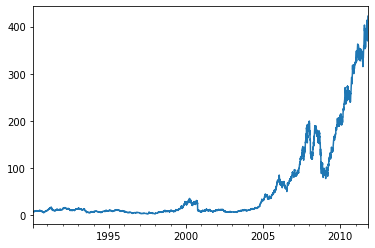

In [153]:
close_px.AAPL.plot()

<AxesSubplot:>

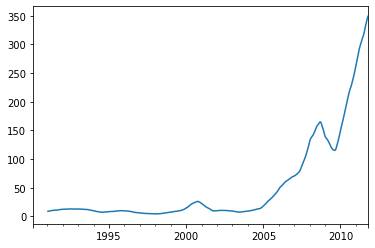

In [154]:
close_px.AAPL.rolling(250).mean().plot()

The expression rolling(250) is similar in behavior to groupby, but instead of group‐
ing it creates an object that enables grouping over a 250-day sliding window. So here
we have the 250-day moving window average of Apple’s stock price.

By default rolling functions require all of the values in the window to be non-NA.
This behavior can be changed to account for missing data and, in particular, the fact
that you will have fewer than window periods of data at the beginning of the time
series (see Figure 11-5):

In [155]:
appl_std250 = close_px.AAPL.rolling(250, min_periods=10).std()
appl_std250[5:12]

1990-02-08         NaN
1990-02-09         NaN
1990-02-12         NaN
1990-02-13         NaN
1990-02-14    0.148189
1990-02-15    0.141003
1990-02-16    0.135454
Freq: B, Name: AAPL, dtype: float64

<AxesSubplot:>

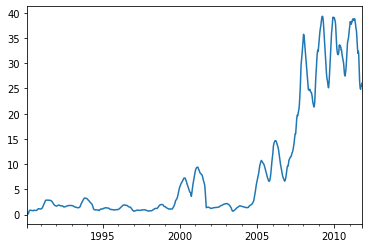

In [156]:
appl_std250.plot()

In order to compute an expanding window mean, use the expanding operator instead
of rolling. The expanding mean starts the time window from the beginning of the
time series and increases the size of the window until it encompasses the whole series.
An expanding window mean on the apple_std250 time series looks like this:

In [157]:
expanding_mean = appl_std250.expanding().mean()

Calling a moving window function on a DataFrame applies the transformation to
each column (see Figure 11-6):


<AxesSubplot:>

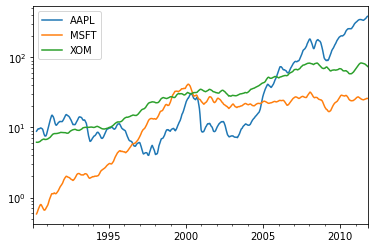

In [158]:
close_px.rolling(60).mean().plot(logy=True)

The rolling function also accepts a string indicating a fixed-size time offset rather
than a set number of periods. Using this notation can be useful for irregular time ser‐
ies. These are the same strings that you can pass to resample. For example, we could
compute a 20-day rolling mean like so:

In [159]:
close_px.rolling('20D').mean()

,AAPL,MSFT,XOM
1990-02-01,7.860000,0.510000,6.120000
1990-02-02,7.930000,0.510000,6.180000
1990-02-05,8.013333,0.510000,6.203333
1990-02-06,8.040000,0.510000,6.210000
1990-02-07,7.986000,0.510000,6.234000
...,...,...,...
2011-10-10,389.351429,25.602143,72.527857
2011-10-11,388.505000,25.674286,72.835000
2011-10-12,388.531429,25.810000,73.400714
2011-10-13,388.826429,25.961429,73.905000


## Exponentially Weighted Functions

An alternative to using a static window size with equally weighted observations is to
specify a constant decay factor to give more weight to more recent observations.
There are a couple of ways to specify the decay factor. A popular one is using a span,
which makes the result comparable to a simple moving window function with win‐
dow size equal to the span.
    
     
Since an exponentially weighted statistic places more weight on more recent observa‐
tions, it “adapts” faster to changes compared with the equal-weighted version.
  
     
pandas has the ewm operator to go along with rolling and expanding. Here’s an
example comparing a 60-day moving average of Apple’s stock price with an EW mov‐
ing average with span=60 (see Figure 11-7):


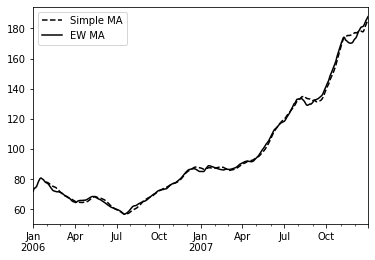

In [161]:
import matplotlib.pyplot as plt
aapl_px = close_px.AAPL['2006':'2007']
ma60 = aapl_px.rolling(30, min_periods=20).mean()
ewma60 = aapl_px.ewm(span=30).mean()
ma60.plot(style='k--', label='Simple MA')
ewma60.plot(style='k-', label='EW MA')
plt.legend()

## Binary Moving Window Functions

Some statistical operators, like correlation and covariance, need to operate on two
time series. As an example, financial analysts are often interested in a stock’s correla‐
tion to a benchmark index like the S&P 500. To have a look at this, we first compute
the percent change for all of our time series of interest:

In [162]:
spx_px = close_px_all['SPX']
spx_rets = spx_px.pct_change()
returns = close_px.pct_change()

The corr aggregation function after we call rolling can then compute the rolling
correlation with spx_rets (see Figure 11-8 for the resulting plot):


<AxesSubplot:>

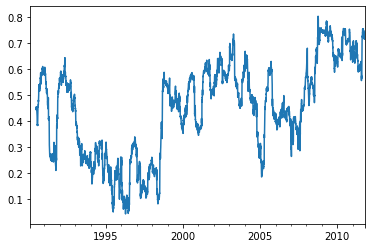

In [163]:
corr = returns.AAPL.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

Suppose you wanted to compute the correlation of the S&P 500 index with many
stocks at once. Writing a loop and creating a new DataFrame would be easy but might
get repetitive, so if you pass a Series and a DataFrame, a function like rolling_corr
will compute the correlation of the Series (spx_rets, in this case) with each column
in the DataFrame (see Figure 11-9 for the plot of the result):

<AxesSubplot:>

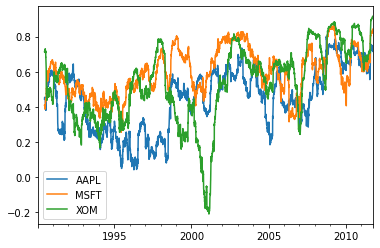

In [164]:
corr = returns.rolling(125, min_periods=100).corr(spx_rets)
corr.plot()

## User-Defined Moving Window Functions

The apply method on rolling and related methods provides a means to apply an
array function of your own devising over a moving window. The only requirement is
that the function produce a single value (a reduction) from each piece of the array.
For example, while we can compute sample quantiles using rolling(...).quan
tile(q), we might be interested in the percentile rank of a particular value over the
sample. The scipy.stats.percentileofscore function does just this (see
Figure 11-10 for the resulting plot):

<AxesSubplot:>

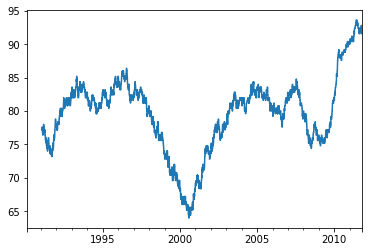

In [165]:
from scipy.stats import percentileofscore
score_at_2percent = lambda x: percentileofscore(x, 0.02)
result = returns.AAPL.rolling(250).apply(score_at_2percent)
result.plot()